# Projected Variational Quantum Dynamics

The projected Variational Quantum Dynamics (p-VQD) algorithm is a quantum algorithm for real time evolution. It's a variational algorithm that projects the state at time $t + \Delta_t$, as calculated with Trotterization, onto a parameterized quantum circuit. 

For a quantum state $|\phi(\theta)\rangle = U(\theta)|0\rangle$ constructed by a parameterized quantum circuit $U(\theta)$ and a Hamiltonian $H$, the update rule can be written as

$$
\theta_{n+1} = \theta_n + \arg\min_{\delta\theta} 1 - |\langle\phi(\theta_n + \delta\theta)|e^{-i\Delta_t H}|\phi(\theta_n)\rangle|^2,
$$

where $e^{-i\Delta_t H}$ is calculated with a Trotter expansion (using e.g. the [`PauliEvolutionGate`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliEvolutionGate.html) in Qiskit!).

The following tutorial explores the p-VQD algorithm in Qiskit, which is implemented available as `qiskit.algorithms.time_evolvers.PVQD`. For details on the algorithm, see the original paper: [Barison et al. Quantum 5, 512 (2021)](https://quantum-journal.org/papers/q-2021-07-28-512/#).

The example we're looking at is the time evolution of the $|00\rangle$ state under the Hamiltonian

$$
    H = 0.1 Z_1 Z_2 + X_1 + X_2,
$$

which is an Ising Hamiltonian on two neighboring spins, up to a time $T=1$, where we want to keep track of the total magnetization $M = Z_1 + Z_2$ as an observable.

In [1]:
from qiskit.quantum_info import SparsePauliOp

final_time = 1
hamiltonian = SparsePauliOp.from_sparse_list([
    ("ZZ", [0, 1], 0.1), ("X", [0], 1), ("X", [1], 1),
], num_qubits=2)
observable = SparsePauliOp(["ZI", "IZ"])

After defining our Hamiltonian and observable, we need to choose the parameterized ansatz we project the update steps onto. We have different choices here, but for real time evolution an ansatz that contains building blocks of the evolved Hamiltonian usually performs very well.

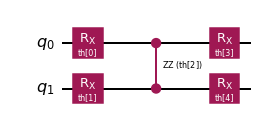

In [2]:
from qiskit.circuit import QuantumCircuit, ParameterVector

theta = ParameterVector("th", 5)
ansatz = QuantumCircuit(2)
ansatz.rx(theta[0], 0)
ansatz.rx(theta[1], 1)
ansatz.rzz(theta[2], 0, 1)
ansatz.rx(theta[3], 0)
ansatz.rx(theta[4], 1)

# you can try different circuits, like:
# from qiskit.circuit.library import EfficientSU2
# ansatz = EfficientSU2(2, reps=1)

ansatz.draw("mpl", style="iqx")

With this ansatz, the $|00\rangle$ state is prepared if all parameters are 0. Hence we'll set the initial parameters to $\theta_0 = 0$:

In [3]:
import numpy as np

initial_parameters = np.zeros(ansatz.num_parameters)

Before running the p-VQD algorithm, we need to select the backend and how we want to calculate the expectation values. Here, we'll perform exact statevector simulations (which are still very fast, as we investigate a 2 qubit system) through the reference primitive implementations found in `qiskit.primitives`.

In [4]:
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute

# the fidelity is used to evaluate the objective: the overlap of the variational form and the trotter step
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

# the estimator is used to evaluate the observables
estimator = Estimator()

Since p-VQD performs a classical optimization in each timestep to determine the best parameters for the projection, we also have to specify the classical optimizer. As a first example we're using BFGS, which typically works well in statevector simulations, but later we can switch to gradient descent.

In [5]:
from qiskit.algorithms.optimizers import L_BFGS_B

bfgs = L_BFGS_B()

Now we can define p-VQD and execute it!

In [6]:
from qiskit.algorithms.time_evolvers.pvqd import PVQD

pvqd = PVQD(
    fidelity,
    ansatz, 
    initial_parameters, 
    estimator=estimator,
    num_timesteps=100, 
    optimizer=bfgs
)

The p-VQD implementation follows Qiskit's time evolution interface, thus we pack all information of the evolution problem into an input class: the `hamiltonian` under which we evolve the state, the `final_time` of the evolution and the observables (`aux_operators`) we keep track of.

In [7]:
from qiskit.algorithms.time_evolvers.time_evolution_problem import TimeEvolutionProblem

problem = TimeEvolutionProblem(hamiltonian, time=final_time, aux_operators=[hamiltonian, observable])

And then run the algorithm!

In [8]:
result = pvqd.evolve(problem)

Now we can have a look at the results, which are stored in a `PVQDResult` object. This class has the fields

* `evolved_state`: The quantum circuit with the parameters at the final evolution time.
* `times`: The timesteps of the time integration. At these times we have the parameter values and evaluated the observables.
* `parameters`: The parameter values at each timestep.
* `observables`: The observable values at each timestep.
* `fidelities`: The fidelity of projecting the Trotter timestep onto the variational form at each timestep.
* `estimated_error`: The estimated error as product of all fidelities.

The energy should be constant in a real time evolution. However, we are projecting the time-evolved state onto a variational form, which might violate this rule. Ideally the energy is still more or less constant. In this evolution here we observe shifts of ~5% of the energy.

Text(0.5, 1.0, 'Energy over time')

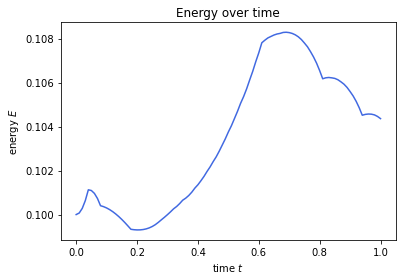

In [9]:
import matplotlib.pyplot as plt

energies = np.real(result.observables)[:, 0]

plt.plot(result.times, energies, color="royalblue")
plt.xlabel("time $t$")
plt.ylabel("energy $E$")
plt.title("Energy over time")

Since we also kept track of the total magnetization of the system, we can plot that quantity too. However let's first compute exact reference values to verify our algorithm results.

In [10]:
import scipy as sc

def exact(final_time, timestep, hamiltonian, initial_state):
    """Get the exact values for energy and the observable."""
    O = observable.to_matrix()
    H = hamiltonian.to_matrix()
    
    energ, magn = [], []  # list of energies and magnetizations evaluated at timesteps timestep
    times = []  # list of timepoints at which energy/obs are evaluated
    time = 0
    while time <= final_time:
        # get exact state at time t
        exact_state = initial_state.evolve(sc.linalg.expm(-1j * time * H))
        # store observables and time
        times.append(time)
        energ.append(exact_state.expectation_value(H).real)
        magn.append(exact_state.expectation_value(observable).real)

        # next timestep
        time += timestep

    return times, energ, magn

In [11]:
from qiskit.quantum_info import Statevector

initial_state = Statevector(ansatz.bind_parameters(initial_parameters))
exact_times, exact_energies, exact_magnetizations = exact(final_time, 0.01, hamiltonian, initial_state)

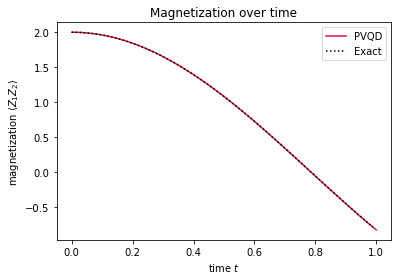

In [12]:
magnetizations = np.real(result.observables)[:, 1]

plt.plot(result.times, magnetizations.real, color="crimson", label="PVQD")
plt.plot(exact_times, exact_magnetizations, ":", color="k", label="Exact")
plt.xlabel("time $t$")
plt.ylabel(r"magnetization $\langle Z_1 Z_2 \rangle$")
plt.title("Magnetization over time")
plt.legend(loc="best")

Looks pretty good!

### Gradient-based optimizations

The `PVQD` class also implements parameter-shift gradients for the loss function and we can use a gradient descent optimization routine

$$
    \theta_{k+1} = \theta_{k} - \eta_k \nabla\ell(\theta_k).
$$

Here we're using a learning rate of 

$$
    \eta_k = 0.1 k^{-0.602}
$$
and 80 optimization steps in each timestep.

In [13]:
from qiskit.algorithms.optimizers import GradientDescent

maxiter = 80
learning_rate = 0.1 * np.arange(1, maxiter + 1) ** (-0.602)
gd = GradientDescent(maxiter, lambda: iter(learning_rate))

In [14]:
pvqd.optimizer = gd

The following cell would take a few minutes to run for 100 timesteps, so we reduce them here.

In [25]:
n = 10
pvqd.num_timesteps = n
problem.time = 0.1

In [16]:
result_gd = pvqd.evolve(problem)

Text(0.5, 1.0, 'Energy over time')

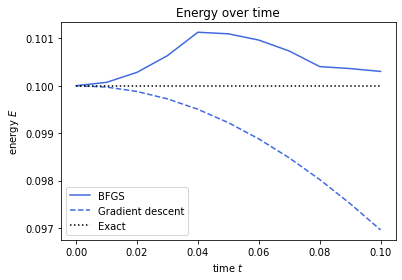

In [26]:
energies_gd = np.real(result_gd.observables)[:, 0]

plt.plot(result.times[:n + 1], energies[:n + 1], "-", color="royalblue", label="BFGS")
plt.plot(result_gd.times, energies_gd, "--", color="royalblue", label="Gradient descent")
plt.plot(exact_times[:n + 1], exact_energies[:n + 1], ":", color="k", label="Exact")
plt.legend(loc="best")
plt.xlabel("time $t$")
plt.ylabel("energy $E$")
plt.title("Energy over time")

We can observe here, that the energy does vary quite a bit! But as we mentioned before, p-VQD does not preserve the energy.

Text(0.5, 1.0, 'Magnetization over time')

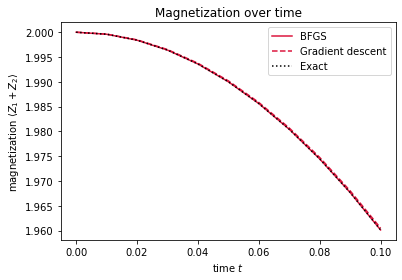

In [27]:
magnetizations_gd = np.real(result_gd.observables)[:, 1]

plt.plot(result.times[:n + 1], magnetizations[:n + 1], "-", color="crimson", label="BFGS")
plt.plot(result_gd.times, magnetizations_gd, "--", color="crimson", label="Gradient descent")
plt.plot(exact_times[:n + 1], exact_magnetizations[:n + 1], ":", color="k", label="Exact")
plt.legend(loc="best")
plt.xlabel("time $t$")
plt.ylabel(r"magnetization $\langle Z_1 + Z_2 \rangle$")
plt.title("Magnetization over time")

The magnetization, however, is computed very precisely.

In [19]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright